# References and Resources 
* Detectron2 Infer Notebook: [ https://www.kaggle.com/slawekbiel/positive-score-with-detectron-3-3-inference ]
* Ensemble prediction Notebook : [ https://www.kaggle.com/ammarnassanalhajali/ensemble-nms-detectron2-inference ]
* Detecttron Intro : [ https://towardsdatascience.com/detectron2-the-basic-end-to-end-tutorial-5ac90e2f90e3 ]
* Another Detectron Intro: [ https://medium.com/@hirotoschwert/digging-into-detectron-2-47b2e794fabd ]
* Inference using cellpose pretrained : [ https://www.kaggle.com/slawekbiel/cellpose-inference-307-lb ]
* Watershed Transform Paper : [ https://arxiv.org/pdf/1611.08303.pdf ]


**Training Notebook :** 
* [ https://www.kaggle.com/virajkadam/sartorius-cell-segmentation-using-detectron2-tr ]

# Note:
* As we are required to use a notebook without Internet for submission, I will detectron2 files downloaded at [ https://www.kaggle.com/slawekbiel/detectron-05 ] for installing detectron.
* I have referred to mainly these fantastic notebook : 1: [ https://www.kaggle.com/slawekbiel/positive-score-with-detectron-3-3-inference/notebook ], 2) [ https://www.kaggle.com/ammarnassanalhajali/ensemble-nms-detectron2-inference ]

**Offline Install Detectron**

In [1]:
import os
import shutil

In [2]:
# pytorch
import torch, torchvision
print(torch.__version__)
if  torch.cuda.is_available():
    print('GPU \n')
    !nvidia-smi

1.9.1
GPU 

Tue Dec 28 17:05:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                            

In [3]:
# os.mkdir('detectron2')
shutil.copytree('../input/detectron-05','detectron2')

'detectron2'

In [4]:
!pip install ./detectron2/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ./detectron2/whls -q
!pip install ./detectron2/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ./detectron2/whls -q
!pip install ./detectron2/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ./detectron2/whls -q
!pip install ./detectron2/whls/detectron2-0.5/detectron2 --no-index --find-links ./detectron2/whls -q

In [5]:
#remove copied files for detectron installation
shutil.rmtree('detectron2')

#### 

# Imports

In [6]:
#general
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
from fastcore.all import *

# detectron
import detectron2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg


# Data dir 

In [7]:
train = pd.read_csv('../input/sartorius-cell-instance-segmentation/train.csv')

# path to competiton directory
comp_dir = Path('../input/sartorius-cell-instance-segmentation')



# get test names 
test_paths = (comp_dir/'test').ls()

print('Test Images Paths  \n',test_paths)

Test Images Paths  
 [Path('../input/sartorius-cell-instance-segmentation/test/7ae19de7bc2a.png'), Path('../input/sartorius-cell-instance-segmentation/test/d8bfd1dafdc4.png'), Path('../input/sartorius-cell-instance-segmentation/test/d48ec7815252.png')]


# Simple EDA on Training Data

**Class prevalence in Images**

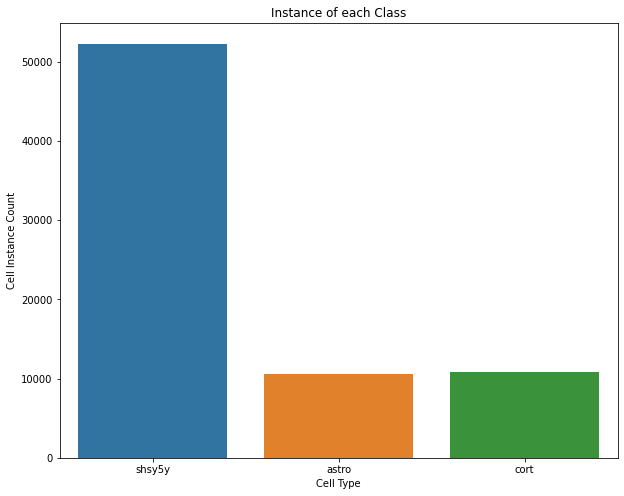

In [8]:
plt.figure(figsize=(10,8))


sns.countplot(data=train,x='cell_type')
plt.title('Instance of each Class')
plt.xlabel('Cell Type')
plt.ylabel('Cell Instance Count')
plt.show()


In [9]:
max_an=train.groupby('id').size().sort_values(ascending=False).reset_index()
print('Maximum annotation in a image are with ID-{}: NUM(Annot) {}'.format(max_an.iloc[0]['id'],max_an[0][0]))

Maximum annotation in a image are with ID-c4121689002f: NUM(Annot) 790


In [10]:
print('Average Annotations per Image',len(train)/train['id'].nunique())

max_an=train.groupby('id').size().sort_values(ascending=False).reset_index()
print('Maximum annotation in a image are with ID-{}: NUM(Annot) {}'.format(max_an.iloc[0]['id'],max_an.iloc[0][0]))

print('Min annotation in a image are with ID-{}: NUM(Annot) {}'.format(max_an.iloc[-1]['id'],max_an.iloc[-1][0]))

Average Annotations per Image 121.42739273927393
Maximum annotation in a image are with ID-c4121689002f: NUM(Annot) 790
Min annotation in a image are with ID-e92c56871769: NUM(Annot) 4


**We can probably use the Information here for setting thresholds**

In [11]:
unique_classes = train['cell_type'].unique()

for clas in unique_classes:
    clas_df= train[train['cell_type']==clas]
    
    print('Average Annotations for class "{}" are {}'.format(clas,len(clas_df)/clas_df['id'].nunique()))
    max_an=clas_df.groupby('id').size().sort_values(ascending=False).reset_index()
    print('Max num of annot for {} ID-{}: NUM(Annot) {}'.format(clas,max_an.iloc[0]['id'],max_an.iloc[0][0]))
    print('Min num of annotation for {} with ID-{}: NUM(Annot) {}'.format(clas,max_an.iloc[-1]['id'],max_an.iloc[-1][0]))
    
    print('-'*20,'.'*10,'-'*20)

Average Annotations for class "shsy5y" are 337.3290322580645
Max num of annot for shsy5y ID-c4121689002f: NUM(Annot) 790
Min num of annotation for shsy5y with ID-f8902ee8890c: NUM(Annot) 49
-------------------- .......... --------------------
Average Annotations for class "astro" are 80.3206106870229
Max num of annot for astro ID-a7b1db2a42fc: NUM(Annot) 594
Min num of annotation for astro with ID-b861811eaff6: NUM(Annot) 5
-------------------- .......... --------------------
Average Annotations for class "cort" are 33.678125
Max num of annot for cort ID-4425efbbacfc: NUM(Annot) 108
Min num of annotation for cort with ID-e92c56871769: NUM(Annot) 4
-------------------- .......... --------------------


# Helper Functions

In [12]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [13]:
def load_img(path):
    im = cv2.imread(str(path))
    return im

def predict_masks(path,
                  Predictor_Model, # predicted model
                  class_thresh, # threshold for each class
                  pixel_thresh,
                  print_predicted_class=False): # pixel threshold for each class
    
    class_dict={'shsy5y':0,
               'astro':1,
               'cort':2}
    
    
    im = load_img(path)
    pred = Predictor_Model(im)#get prediction
    pred_class = torch.mode(pred['instances'].pred_classes)[0] # get classes
    
    if print_predicted_class:
        print(f'predicted class is {[i for i in class_dict if class_dict[i]==pred_class]}')
    
    take = pred['instances'].scores >= class_thresh[pred_class] # segment pixels based on what class it is from
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    used = np.zeros(im.shape[:2], dtype=int) 
    
    res = []
    
    for mask in pred_masks:
        mask = mask * (1-used)
        if mask.sum() >= pixel_thresh[pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
            
    return res

# Load and configure trained Detectron2 Instance


In [14]:
# set params 


detect_per_img = 1200

# Individual Thresholds for each class
class_thresh= [.15, .45, .55]
#pixel_thresh
pixel_thresh= [50, 80, 60]

# for predictions
ids, masks=[],[]  # img ids, mask annotations

img_masks = []

**CONFIG**

In [15]:
#config dict
cfg = get_cfg()
#get model arch
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
#mask format
cfg.INPUT.MASK_FORMAT='bitmask'
#num of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
# weights from training notebook model
cfg.MODEL.WEIGHTS = '../input/sartorius-detectron2-model/output/model_final.pth' 
#num of detections per image
cfg.TEST.DETECTIONS_PER_IMAGE = detect_per_img


# **Inference**

In [16]:
predictor = DefaultPredictor(cfg)

for i,path in enumerate(test_paths):
    encoded_masks = predict_masks(path=path,
                                  Predictor_Model=predictor, # predicted model
                                  class_thresh = class_thresh, # threshold for each class
                                  pixel_thresh = pixel_thresh,
                                  print_predicted_class=True) # pixel threshold(area) for each class
    
    
    img_masks.append(encoded_masks) # append masks for further visualization
    for encoding in encoded_masks:
        #save img ids
        ids.append(path.stem)
        # save individual encodings
        masks.append(encoding)
        
print('Number of Annotations predicted for 3 Test Images are ',len(masks))

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:461.)
  return torch.floor_divide(self, other)


predicted class is ['shsy5y']
predicted class is ['astro']
predicted class is ['astro']
Number of Annotations predicted for 3 Test Images are  251


# Visualizing predictions

Checking first test example


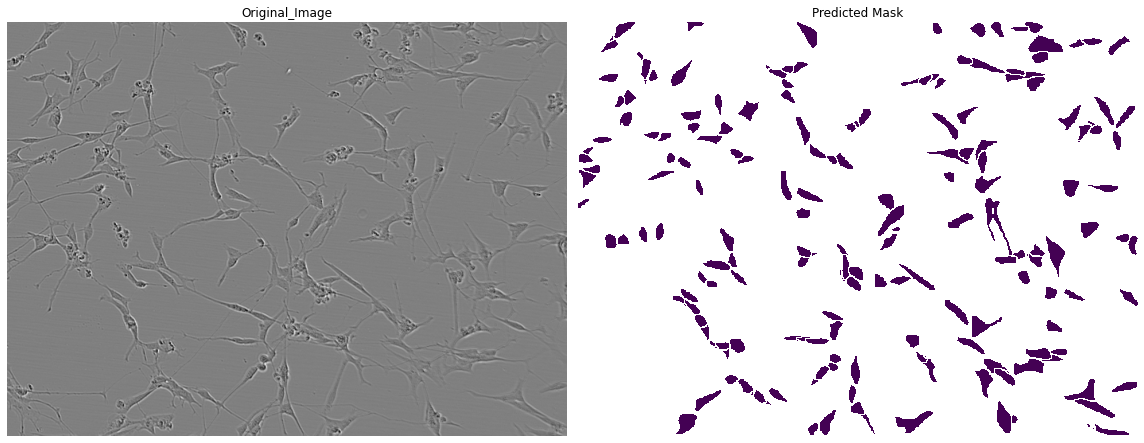

In [17]:
def show_pred(orig_img_path,predicted_mask):
    fig,ax=plt.subplots(1,2,figsize=(16,8))
    
    ax[0].set_title('Original_Image')
    ax[0].imshow(load_img(orig_img_path))
    ax[0].axis('off')
    
    
    ax[1].set_title('Predicted Mask')
    ax[1].axis('off')
    
    for enc in predicted_mask:
        decoded= rle_decode(enc)
        ax[1].imshow(np.ma.masked_where(decoded==0, decoded))
        
    plt.tight_layout()
    plt.show()
    
    
    
    
print('Checking first test example')
show_pred(test_paths[0],img_masks[0])

Checking second test example


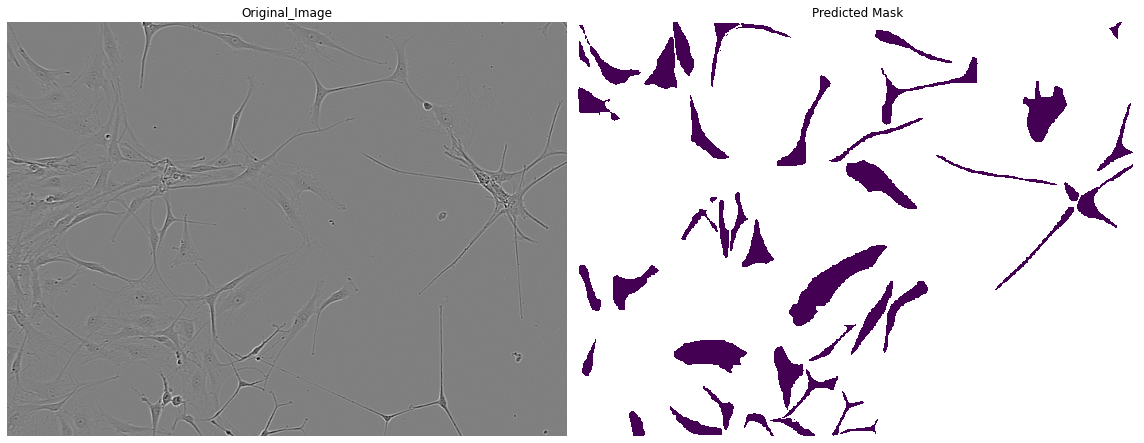

In [18]:
print('Checking second test example')
show_pred(test_paths[1],img_masks[1])

Checking third test example


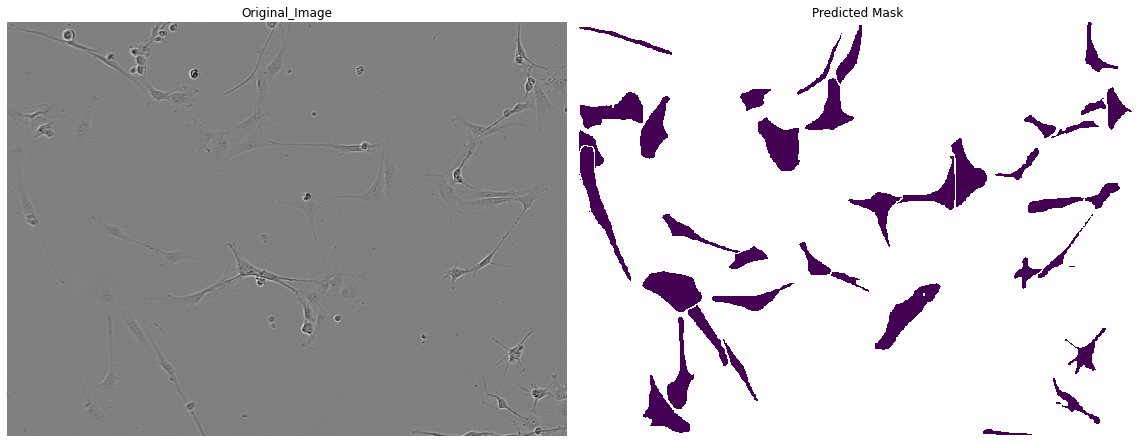

In [19]:
print('Checking third test example')
show_pred(test_paths[2],img_masks[2])

# Visualizing predictions on some random train_images

predicted class is ['cort']
Checking random example from train


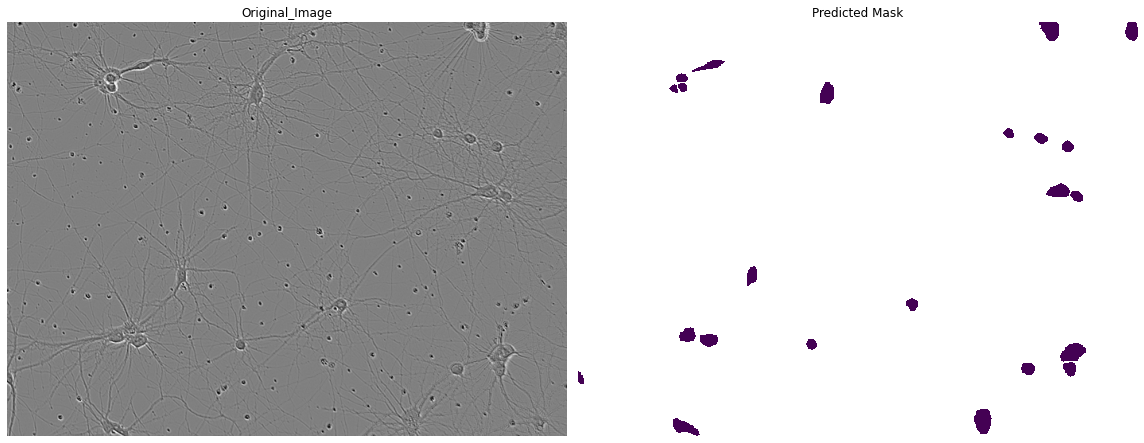

In [20]:
im_path='../input/sartorius-cell-instance-segmentation/train/0323e81d23d9.png'

pred = predict_masks(path=im_path,
                      Predictor_Model=predictor, # predicted model
                      class_thresh = class_thresh, # threshold for each class
                      pixel_thresh = pixel_thresh,
                      print_predicted_class=True) # pixel threshold(area) for each class


print('Checking random example from train')
show_pred(im_path,pred)

predicted class is ['shsy5y']
Checking random example from train


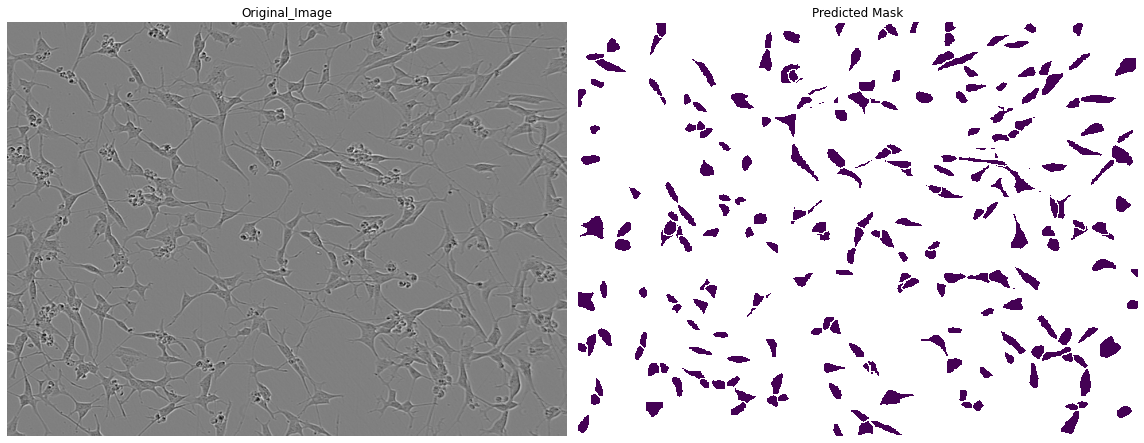

In [21]:
im_path='../input/sartorius-cell-instance-segmentation/train/0c5938ac5e3c.png'
pred = predict_masks(path=im_path,
                      Predictor_Model=predictor, # predicted model
                      class_thresh = class_thresh, # threshold for each class
                      pixel_thresh = pixel_thresh,
                      print_predicted_class=True) # pixel threshold(area) for each class


print('Checking random example from train')
show_pred(im_path,pred)

predicted class is ['astro']
Checking random example from train


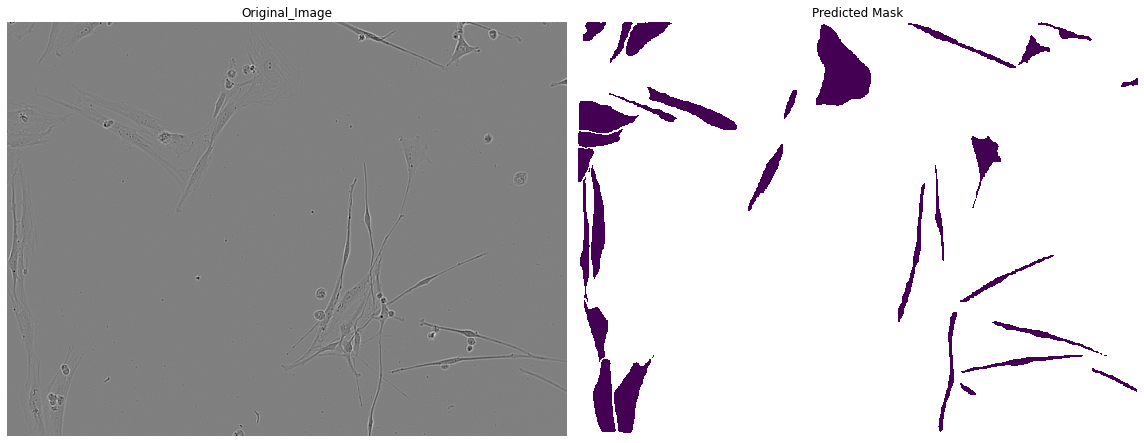

In [22]:
im_path = '../input/sartorius-cell-instance-segmentation/train/17754cb5b287.png'
pred = predict_masks(path=im_path,
                      Predictor_Model=predictor, # predicted model
                      class_thresh = class_thresh, # threshold for each class
                      pixel_thresh = pixel_thresh,
                      print_predicted_class=True) # pixel threshold(area) for each class


print('Checking random example from train')
show_pred(im_path,pred)

predicted class is ['cort']
Checking random example from train


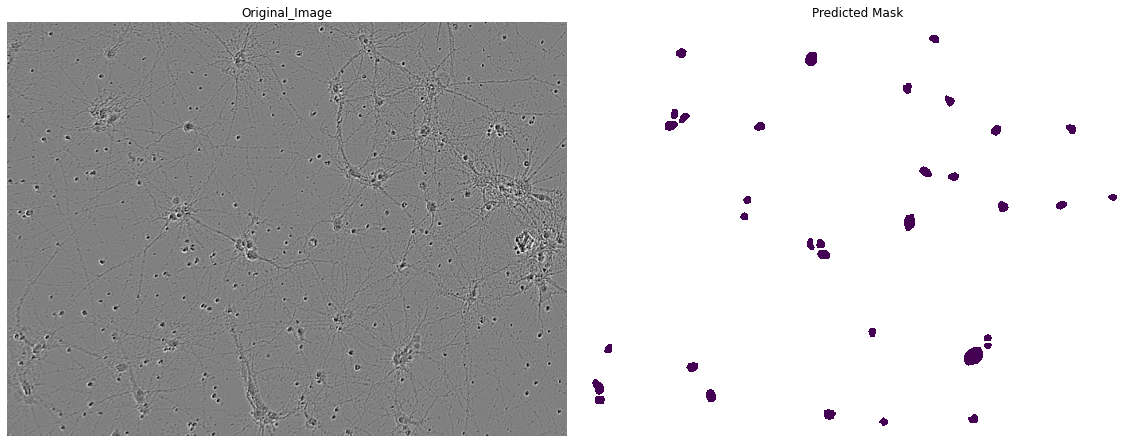

In [23]:
im_path = '../input/sartorius-cell-instance-segmentation/train/0f7d009bc5d3.png'
pred = predict_masks(path=im_path,
                      Predictor_Model=predictor, # predicted model
                      class_thresh = class_thresh, # threshold for each class
                      pixel_thresh = pixel_thresh,
                      print_predicted_class=True) # pixel threshold(area) for each class


print('Checking random example from train')
show_pred(im_path,pred)

predicted class is ['astro']
Checking random example from train


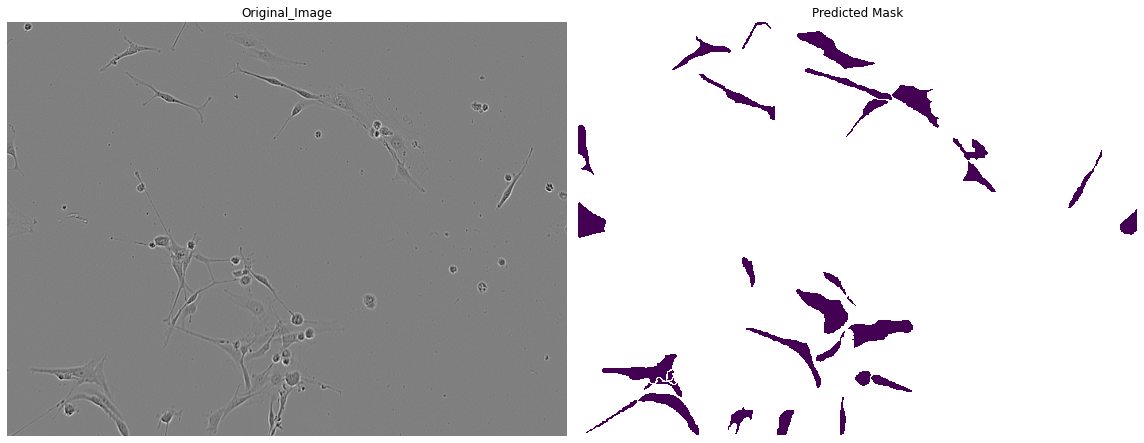

In [24]:
im_path = '../input/sartorius-cell-instance-segmentation/train/0e1e2b68fa58.png'
pred = predict_masks(path=im_path,
                      Predictor_Model=predictor, # predicted model
                      class_thresh = class_thresh, # threshold for each class
                      pixel_thresh = pixel_thresh,
                      print_predicted_class=True) # pixel threshold(area) for each class


print('Checking random example from train')
show_pred(im_path,pred)

predicted class is ['cort']
Checking random example from train


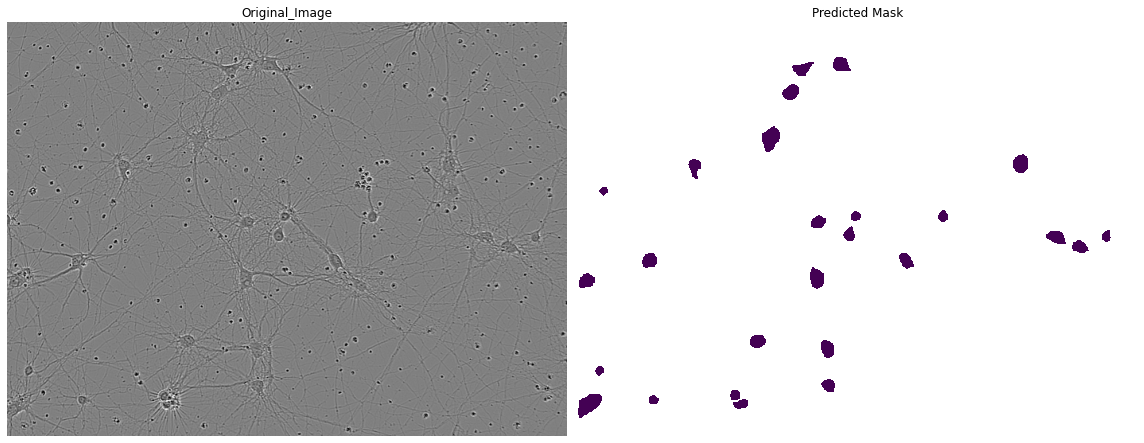

In [25]:
im_path = '../input/sartorius-cell-instance-segmentation/train/097d60b2cf71.png'
pred = predict_masks(path=im_path,
                      Predictor_Model=predictor, # predicted model
                      class_thresh = class_thresh, # threshold for each class
                      pixel_thresh = pixel_thresh,
                      print_predicted_class=True) # pixel threshold(area) for each class


print('Checking random example from train')
show_pred(im_path,pred)

predicted class is ['cort']
Checking random example from train


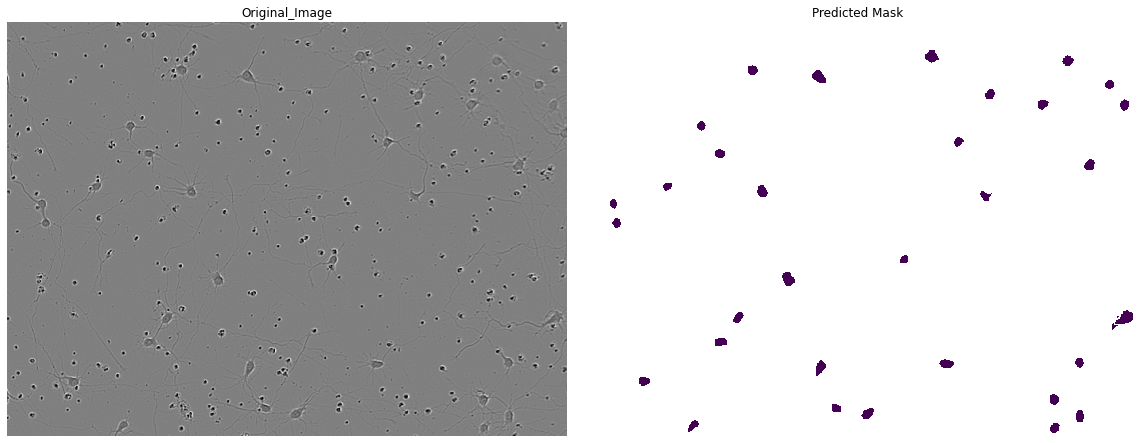

In [26]:
im_path = '../input/sartorius-cell-instance-segmentation/train/0cfdeeb0dded.png'
pred = predict_masks(path=im_path,
                      Predictor_Model=predictor, # predicted model
                      class_thresh = class_thresh, # threshold for each class
                      pixel_thresh = pixel_thresh,
                      print_predicted_class=True) # pixel threshold(area) for each class


print('Checking random example from train')
show_pred(im_path,pred)

predicted class is ['astro']
Checking random example from train


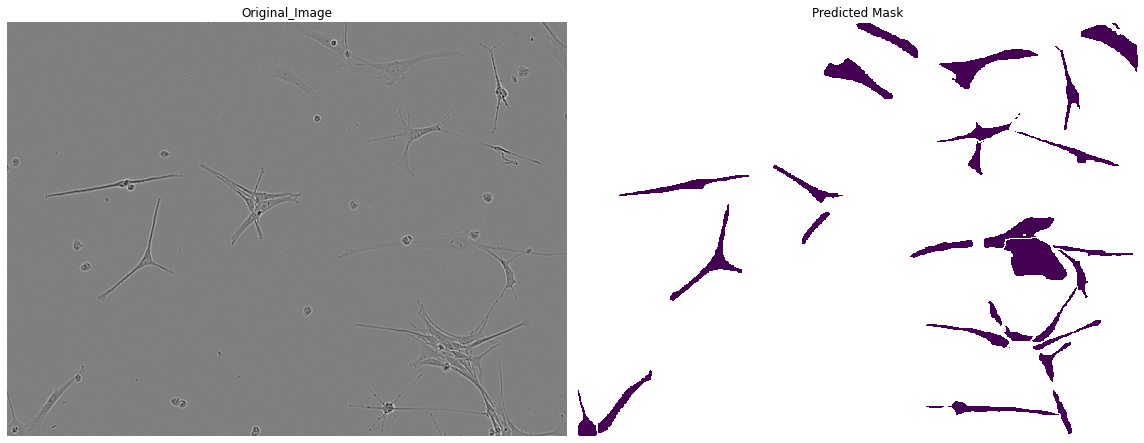

In [27]:
im_path ='../input/sartorius-cell-instance-segmentation/train/182c3da676bd.png'
pred = predict_masks(path=im_path,
                      Predictor_Model=predictor, # predicted model
                      class_thresh = class_thresh, # threshold for each class
                      pixel_thresh = pixel_thresh,
                      print_predicted_class=True) # pixel threshold(area) for each class


print('Checking random example from train')
show_pred(im_path,pred)

# Submission

In [28]:
df=pd.DataFrame({'id':ids, 'predicted':masks})
df.to_csv('submission.csv', index=False)

df.head()

,id,predicted
0,7ae19de7bc2a,151743 12 152445 16 153148 17 153850 20 154554...
1,7ae19de7bc2a,96418 4 97121 6 97825 7 98529 8 99233 8 99937 ...
2,7ae19de7bc2a,139541 5 140244 7 140948 7 141652 8 142356 9 1...
3,7ae19de7bc2a,177345 13 178041 23 178744 25 179448 25 180152...
4,7ae19de7bc2a,354409 5 355112 7 355815 8 356517 11 357220 12...


In [29]:
df.groupby('id').size()

id
7ae19de7bc2a    173
d48ec7815252     37
d8bfd1dafdc4     41
dtype: int64